<a href="https://colab.research.google.com/github/sundarjhu/AstrostatsIRyA2023/blob/main/Statistics_For_Astronomers_20231018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kernel density estimate
##### Let's start by studying how kernels are used to represent the data.
##### We will choose a very small dataset, with the data points well separated (we will force the bandwidth to be smaller than the typical separation between the data points to better visualise the workings of the kernel).

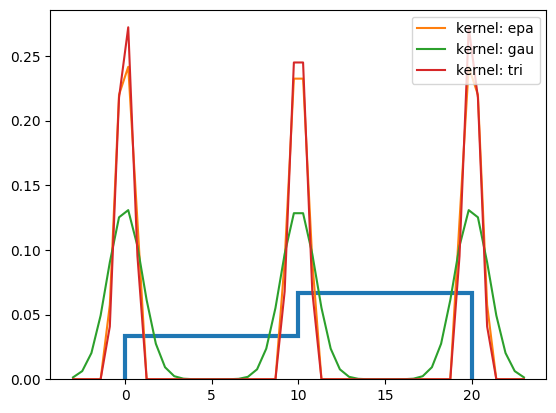

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kde import KDEUnivariate

data = np.array([0.0, 10.0, 20.0])

plt.hist(data, bins='scott', histtype='step', density=True, lw=3)
for kernel in ['epa', 'gau', 'tri']:
  kde = KDEUnivariate(data)
  kf = kde.fit(bw=1, kernel=kernel, fft=False)
  plt.plot(kde.support, kde.density, label=f'kernel: {kernel}')

plt.legend(loc='best')

##### The above is a comparison of KDEs using three different kernels with the same bandwidth.
##### Depending on the kernel, the bandwidth is used in different ways to specify the kernel shape. For the triangular and Epanechnikov kernels, the distance between the points where the kernel drops to zero is equal to the specified bandwidth. For the Gaussian kernel, the bandwidth is taken to be the standard deviation, which means that the Gaussian kernel has influnce over a larger data range than the other two kernels.

##### $\texttt{density=True}$ was set for the histogram so we can directly compare estimated probability densities for all four estimates. The histogram bin size was calculated automatically ($\texttt{bins='scott'}$), resulting in a more or less uniform distribution. The KDEs all show equal density at each point because the bandwidths were chosen to be small on purpose. If the KDE is allowed to determine the bandwidth automatically, the resulting density estimate will be much more comparable to the histogram, as seen below.

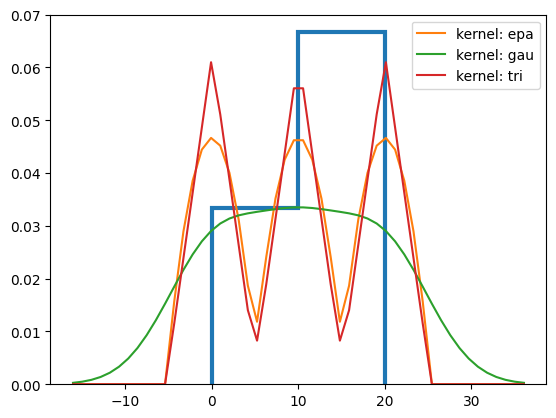

In [52]:
data = np.array([0.0, 10.0, 20.0])

plt.hist(data, bins='scott', histtype='step', density=True, lw=3)
for kernel in ['epa', 'gau', 'tri']:
  kde = KDEUnivariate(data)
  kf = kde.fit(bw='scott', kernel=kernel, fft=False)
  plt.plot(kde.support, kde.density, label=f'kernel: {kernel}')

plt.legend(loc='best')

#### Note that the density estimate from the histogram hasn't changed, it's just that the KDEs now span the same range of densities as the histogram.
##### The Epanechnikov and triangular kernels still retain some of the variance seen in the data, while the Gaussian kernel seems to have oversmoothed the data. The histogram estimate is somewhere in between these two extremes.

### Application to astronomical datasets
##### Let's compare the $K_{\rm s}$-band luminosity functions of globular clusters in the Milky Way and M31 again.
##### We will first compute a histogram and KDE for each dataset, then compute the cumulative distributions from the KDEs and compare these for the two galaxies.

Number of MW and M31 clusters: 82 and 360 respectively


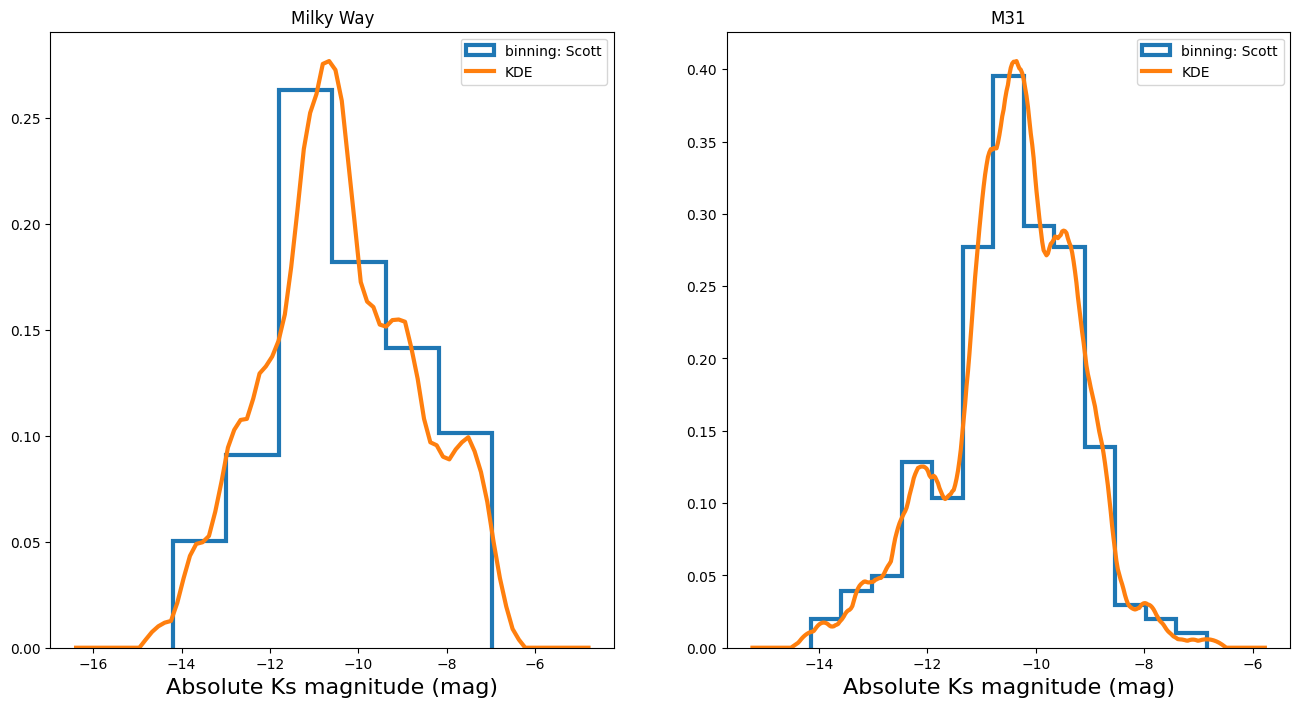

In [70]:
seed=1001
#Our data set consists of the Ks luminosity functions for Milky Way and M31 globular clusters.
data1 = np.loadtxt('https://www.irya.unam.mx/gente/s.srinivasan/Teaching/Statistics2023/python/datasets/globular_clusters/MW_GCs.txt')
data2 = np.loadtxt('https://www.irya.unam.mx/gente/s.srinivasan/Teaching/Statistics2023/python/datasets/globular_clusters/M31_GCs.txt')
print(f"Number of MW and M31 clusters: {len(data1)} and {len(data2)} respectively")
#M31 magnitudes not corrected for distance!
data2 = data2 - 24.9

#Compute KDEs and compare them to histograms with classical binning
kde1 = KDEUnivariate(data1)
kde2 = KDEUnivariate(data2)
#We can also specify which method is to be used to compute the bandwidth
#     methods available: 'biw', 'cos', 'epa', 'gau', 'tri', 'triw', 'uni'
kernel = 'epa'
kde1.fit(bw = 'scott', kernel = kernel, fft = False)
kde2.fit(bw = 'scott', kernel = kernel, fft = False)

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
_ = ax[0].hist(data1, bins = 'scott', histtype = 'step', label = 'binning: Scott', density = True, lw = 3)
_ = ax[0].plot(kde1.support, kde1.density, lw = 3, label = 'KDE')
_ = ax[0].set_title('Milky Way')
_ = ax[0].legend(loc = 'best')
_ = ax[0].set_xlabel('Absolute Ks magnitude (mag)', fontdict = {'size': 16})
_ = ax[1].hist(data2, bins = 'scott', histtype = 'step', label = 'binning: Scott', density = True, lw = 3)
_ = ax[1].plot(kde2.support, kde2.density, lw = 3, label = 'KDE')
_ = ax[1].set_title('M31')
_ = ax[1].legend(loc = 'best')
_ = ax[1].set_xlabel('Absolute Ks magnitude (mag)', fontdict = {'size': 16})

##### Now, the cumulative functions

##### I've implemented this in a roundabout way because the kde.cdf method returns NaNs. Perplexity tells me this happens when $\texttt{bins}$ is set to either $\texttt{`scott'}$ or $\texttt{`scott'}$. Oh well, the lesson is that if you're using KDEs for your research, you might want to use cross-validation to determine the bandwidth.

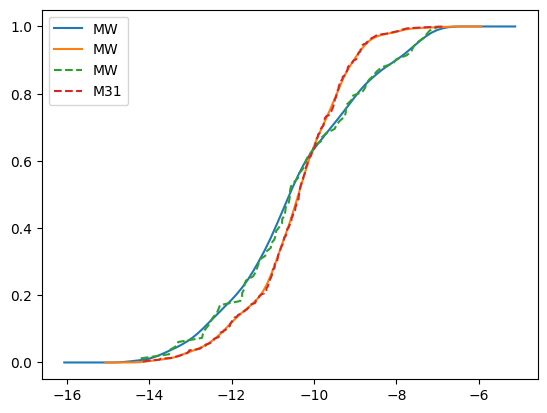

In [69]:
cdf1 = np.cumsum(kde1.density) / np.sum(kde1.density)
cdf2 = np.cumsum(kde2.density) / np.sum(kde2.density)
plt.plot(kde1.support, cdf1, label='MW')
plt.plot(kde2.support, cdf2, label='MW')

# We can compare these to the ECDF
from statsmodels.distributions.empirical_distribution import ECDF
cdf1 = ECDF(data1)
cdf2 = ECDF(data2)
plt.plot(cdf1.x, cdf1.y, '--', label='MW')
plt.plot(cdf2.x, cdf2.y, '--', label='M31')
plt.legend(loc='best')

##### Phew, alright, the cumulative distributions from the KDE are much smoother versions of the ECDFs as expected.
##### The ECDF for M31 is much smoother because that dataset has many more clusters.

### KDE prediction
##### The KDE produces a $\texttt{fit}$ object which can be used to predict the density at an arbitrary point, even if it wasn't already part of the dataset. This is a very useful application! Use the $\texttt{evaluate}$ method as follows:

In [74]:
Ksmag = -12
kde1_predicted = kde1.evaluate(Ksmag)[0]
kde2_predicted = kde2.evaluate(Ksmag)[0]
print(f"The MW and M31 KDEs at K_s = {Ksmag} mag are {np.round(kde1_predicted, 2)} and {np.round(kde2_predicted, 2)} respectively ")

The MW and M31 KDEs at K_s = -12 mag are 0.14 and 0.12 respectively 


##### We can compare this prediction to the KDE of the rest of the data

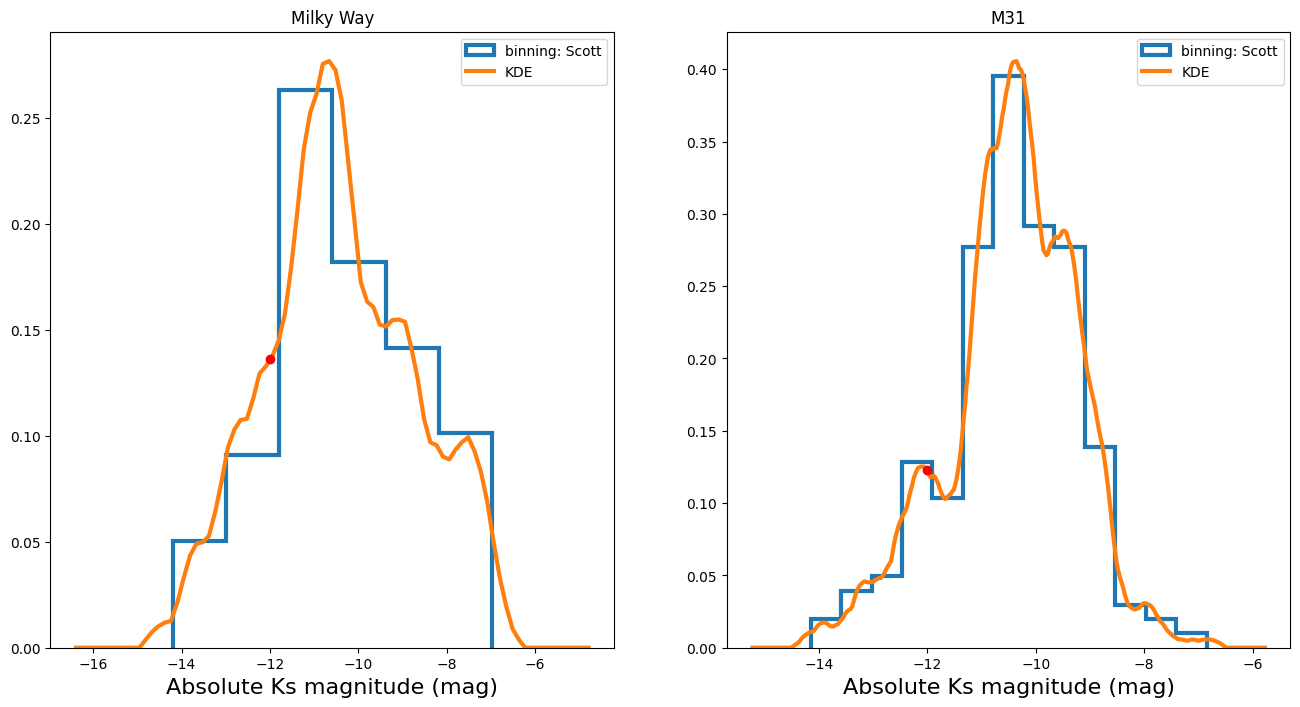

In [76]:
fig, ax = plt.subplots(1, 2, figsize = (16, 8))
_ = ax[0].hist(data1, bins = 'scott', histtype = 'step', label = 'binning: Scott', density = True, lw = 3)
_ = ax[0].plot(kde1.support, kde1.density, lw = 3, label = 'KDE')
_ = ax[0].plot(Ksmag, kde1_predicted, 'ro')
_ = ax[0].set_title('Milky Way')
_ = ax[0].legend(loc = 'best')
_ = ax[0].set_xlabel('Absolute Ks magnitude (mag)', fontdict = {'size': 16})
_ = ax[1].hist(data2, bins = 'scott', histtype = 'step', label = 'binning: Scott', density = True, lw = 3)
_ = ax[1].plot(kde2.support, kde2.density, lw = 3, label = 'KDE')
_ = ax[1].plot(Ksmag, kde2_predicted, 'ro')
_ = ax[1].set_title('M31')
_ = ax[1].legend(loc = 'best')
_ = ax[1].set_xlabel('Absolute Ks magnitude (mag)', fontdict = {'size': 16})

##### One application of the $\texttt{predict}$ method is when you have to compare data to a model (e.g., masses of stars to a power-law IMF).